<a href="https://colab.research.google.com/github/Leeyeji13/Section2_project/blob/main/AI_13_%EC%9D%B4%EC%98%88%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 항공 이용 고객 만족도 분류

## < 데이터 업로드 >

In [2]:
!pip install pandas-profiling==3.1.0

     |████████████████████████████████| 261 kB 5.4 MB/s 
     |████████████████████████████████| 10.9 MB 32.6 MB/s 
     |████████████████████████████████| 690 kB 40.1 MB/s 
     |████████████████████████████████| 303 kB 43.5 MB/s 
     |████████████████████████████████| 102 kB 8.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 3.1 MB 34.8 MB/s 
     |████████████████████████████████| 596 kB 38.4 MB/s 
     |████████████████████████████████| 812 kB 31.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=490749dc1182399a0b18b06ece393b6a93e2b7b6f2c28a248d8f710e77c61fe1
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=cd9931694be70a256379d35e211f8c595be7a3fab9809ddf07ba241702ab5301
  

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (17.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [4]:
from google.colab import files
import pandas as pd
import io
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rc('font', family='NanumBarunGothic')

In [5]:
uploaded1 = files.upload()
uploaded2 = files.upload()

Saving train.csv to train.csv


Saving test.csv to test.csv


In [63]:
train = pd.read_csv(io.StringIO(uploaded1['train.csv'].decode('utf8')))
test = pd.read_csv(io.StringIO(uploaded2['test.csv'].decode('utf8')))

In [64]:
train.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [65]:
test.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

## <타겟 특성의 불균형 확인>

In [68]:
train['satisfaction'].value_counts(normalize = True)

neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: satisfaction, dtype: float64

Text(0.5, 1.0, "Passengers' Satisfaction Rate")

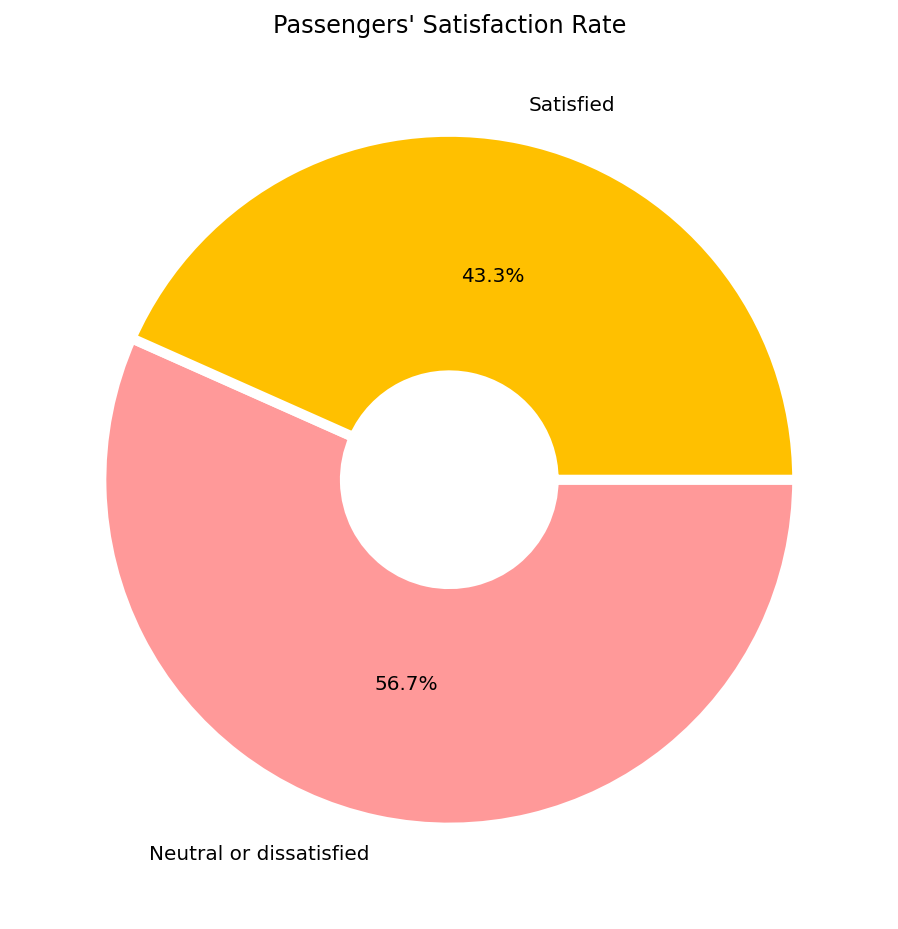

In [69]:
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.figure(figsize=(8, 8))
train['satisfaction'].value_counts().plot(kind = "pie", autopct = '%1.1f%%', colors = ['#ff9999', '#ffc000'], counterclock = False, wedgeprops = wedgeprops, labels = ["Neutral or dissatisfied", "Satisfied"])
plt.ylabel("")
plt.title("Passengers' Satisfaction Rate")

***=> Baseline : 0.57***

## < 결측치 >

In [70]:
train.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [71]:
test.isna().sum()

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


In [72]:
train['Arrival Delay in Minutes'] = train['Arrival Delay in Minutes'].fillna(0)
test['Arrival Delay in Minutes'] = test['Arrival Delay in Minutes'].fillna(0)

In [73]:
train.isna().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [74]:
test.isna().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

## < 시각화 >

In [75]:
train = train.drop(['Unnamed: 0', 'id'], axis = 1)
test = test.drop(['Unnamed: 0', 'id'], axis = 1)
train.shape, test.shape

((103904, 23), (25976, 23))

In [76]:
train.columns = [c.replace(' ','_') for c in train.columns]
test.columns = [c.replace(' ','_') for c in test.columns]

## < 범주형 특성 인코딩 >

In [77]:
train.dtypes == 'object'

Gender                                True
Customer_Type                         True
Age                                  False
Type_of_Travel                        True
Class                                 True
Flight_Distance                      False
Inflight_wifi_service                False
Departure/Arrival_time_convenient    False
Ease_of_Online_booking               False
Gate_location                        False
Food_and_drink                       False
Online_boarding                      False
Seat_comfort                         False
Inflight_entertainment               False
On-board_service                     False
Leg_room_service                     False
Baggage_handling                     False
Checkin_service                      False
Inflight_service                     False
Cleanliness                          False
Departure_Delay_in_Minutes           False
Arrival_Delay_in_Minutes             False
satisfaction                          True
dtype: bool

In [78]:
test.dtypes == 'object'

Gender                                True
Customer_Type                         True
Age                                  False
Type_of_Travel                        True
Class                                 True
Flight_Distance                      False
Inflight_wifi_service                False
Departure/Arrival_time_convenient    False
Ease_of_Online_booking               False
Gate_location                        False
Food_and_drink                       False
Online_boarding                      False
Seat_comfort                         False
Inflight_entertainment               False
On-board_service                     False
Leg_room_service                     False
Baggage_handling                     False
Checkin_service                      False
Inflight_service                     False
Cleanliness                          False
Departure_Delay_in_Minutes           False
Arrival_Delay_in_Minutes             False
satisfaction                          True
dtype: bool

In [79]:
def transform_satisfaction(x):
  if x == 'satisfied':
    return 1
  elif x == 'neutral or dissatisfied':
    return 0
  else:
    return -1

def transform_class(x):
  if x == 'Business':
    return 2
  elif x == 'Eco plus':
    return .1
  elif x == 'Eco':
    return 0
  else:
    return -1

def transform_type_of_travel(x):
  if x == 'Personal Travel':
    return 1
  elif x == 'Business travel':
    return 0
  else:
    return -1

def transform_customer_type(x):
  if x == 'Loyal Customer':
    return 1
  elif x == 'disloyal Customer':
    return 0
  else:
    return -1

def transform_gender(x):
  if x == 'Female':
    return 1
  elif x == 'Male':
    return 0
  else:
    return -1

In [ ]:
def encoding(df):
  df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
  df['Class'] = df['Class'].apply(transform_class)
  df['Type_of_Travel'] = df['Type_of_Travel'].apply(transform_type_of_travel)
  df['Customer_Type'] = df['Customer_Type'].apply(transform_customer_type)
  df['Gender'] = df['Gender'].apply(transform_gender)

In [80]:
encoding(train)
encoding(test)

In [81]:
train.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,0,1,13,1,-1,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,0,0,25,0,2,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,1,26,0,2,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,1,1,25,0,2,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,0,1,61,0,2,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [82]:
test.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,1,1,52,0,0,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,1
1,1,1,36,0,2,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,1
2,0,0,20,0,0,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,0
3,0,1,44,0,2,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,1
4,1,1,49,0,0,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,1


## < 이상치 확인 >

## < 표준화, 정규화 >

## < 상관관계 >

## < Train/Test/Val 나누기 >

## < 특성선택 >

## < 특성 중요도 >

## < 순열 중요도 >

## < 모델 만들기 >

## < 결론 >